_students: Rotem Gabay & Michael Gokhman_

# Assignment: Unsupervised Machine Learning \ Clustering

---
---
<font color='blue'>**Comment**: As the example of the correct solution we chose the work of the previous year students - Rotem Gabay and Michael Gokhman.</font>
---
---
---

## Part 1: Partitional Clustering

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Read blood test results as an EMR from an Excel file

In [ ]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Use K-Means to create clusters according to variables of uniform distribution

In [ ]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

# Run the K-Means algorithm, assuming the correct number of clusters is 5
y_pred_KMeans1 = KMeans(n_clusters=5, random_state=0).fit_predict(EMR3d1)

### Make a 3D chart

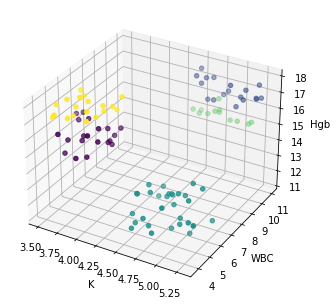

In [ ]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Task 1
Implement  Lloyd's Algorithm for solving the K-Means problem, as shown in class.
By examining the WCSS, choose a proper threshold to determine algorithm convergence.

Compare your results to the _sklearn_ version - what can affect any differences you might've got?

sklearn's WCSS:  86.25882
our WCSS: 89.43501403944998


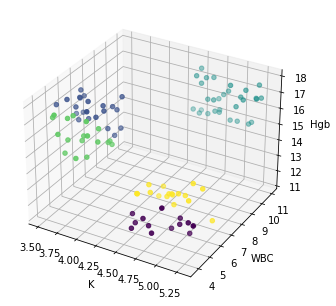

In [ ]:
# Add your code for Task 1 after this line, and keep it in this cell.

# Implement K-Means (X being the data)
class k_means:
    def __init__(self, k, tol=1e-4, init="k-means++", random_state=0):
        if random_state is not None: 
            np.random.seed(random_state)

        self.k = k
        self.tol = tol
        self.init = init
        self._WCSS = 0
        
    def fit(self, X):
        if self.init == "k-means++":
            self.__init_centroids_kpp(X)
        else:
            self.__init_centroids_random(X)
        
        distances = np.zeros((X.shape[0], self.k), dtype=np.float64)
        
        prevWCSS = float("inf")
        WCSS = 0 
        while not self.__is_converged(WCSS, prevWCSS, self.tol):            
            # Choose class by picking the closest centroid
            for i, centroid in enumerate(self._centroids):
                distances[:, i] = self.__eucl_distance(centroid, X).T
                
            clusters = np.argmin(distances, axis=1)
            
            # Update centroids with new mean
            prevWCSS = WCSS
            WCSS = 0
            for cluster in range(self.k):
                cluster_points = X[clusters==cluster]
                centroid = np.mean(cluster_points, axis=0)
                
                self._centroids[cluster, :] = centroid

                cluster_WCSS = np.sum(
                    self.__eucl_distance(centroid, cluster_points))
                WCSS += cluster_WCSS
        
        self._WCSS = WCSS        
    
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.k), dtype=np.float64)
        for i, centroid in enumerate(self._centroids):
            distances[:, i] = self.__eucl_distance(centroid, X).T
        
        clusters = np.argmin(distances, axis=1)
        return clusters
    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)
    
    @staticmethod
    def __eucl_distance(points, centroid):
        return np.linalg.norm(points - centroid, axis=1)
    
    @staticmethod
    def __is_converged(newWCSS, prevWCSS, tol):
        return np.abs(newWCSS - prevWCSS) < tol
    
    def __init_centroids_random(self, X):
        k_random_rows_idx = np.random.choice(
            np.arange(X.shape[0]), self.k, replace=False)
        self._centroids = X[k_random_rows_idx, :]

    def __init_centroids_kpp(self, X):    
        # Pick first centroid:
        random_row_i = np.random.choice(np.arange(X.shape[0]), 1)
        centroids = X[random_row_i]
       
        # Pick remaining centroids:
        for k_i in range(1, self.k):
            dists = np.zeros((X.shape[0], k_i), dtype=np.float64)
            for i, centroid in enumerate(centroids):
                dists[:, i] = self.__eucl_distance(centroid, X).T
            
            nearest_dists = np.amin(dists, axis=1)
            
            square_dists = np.square(nearest_dists)
            probs = square_dists / square_dists.sum()
            next_row_i = np.random.choice(
                np.arange(X.shape[0]), 1, p=probs)
            new_centroid = X[next_row_i].reshape(1, -1)

            centroids = np.append(centroids, new_centroid, axis=0)
            
            X = np.delete(X, next_row_i, 0)
            
        self._centroids = centroids
    
    def get_WCSS(self):
        return self._WCSS
    
    def get_centroids(self):
        return self._centroids
    
km = k_means(k=5)
km.fit(EMR3d1)
y_pred_KMeans_ours = km.predict(EMR3d1)
make_chart(EMR3d1, y_pred_KMeans_ours, variables1)

sk_km = KMeans(n_clusters=5, random_state=0)
sk_km.fit(EMR3d1)

print("sklearn's WCSS: ", sk_km.inertia_)
print("our WCSS:", km.get_WCSS())

Ours and sklearn's KMeans got a very similar, but not exactly same WCSS (89.44 vs. 85.72).
Some possible explanations for the diffrence:
* the selection of the initial points can affect the clusters that will be created, especially in this case where there are no 5 clearly seperable clusters in this dataset.
* we might have different stopping conditions.


---
---
<font color='blue'>**Comment**: It's one of the possible variants of implementation. It wasn't obligatory to implement "k-means++" initialization; if you solved the task with the random initialization, it was completely ok (of course, there will be some differences in clustering results, due to the random initialization).</font>
---
---
---


## Task 2

Humans can clearly spot 3 clusters, however, for machines it's much harder to "learn" that. In the above implementation, K-Means was given the value of 5 as K.
Develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class
3. Showing the final clusters in a 3D chart

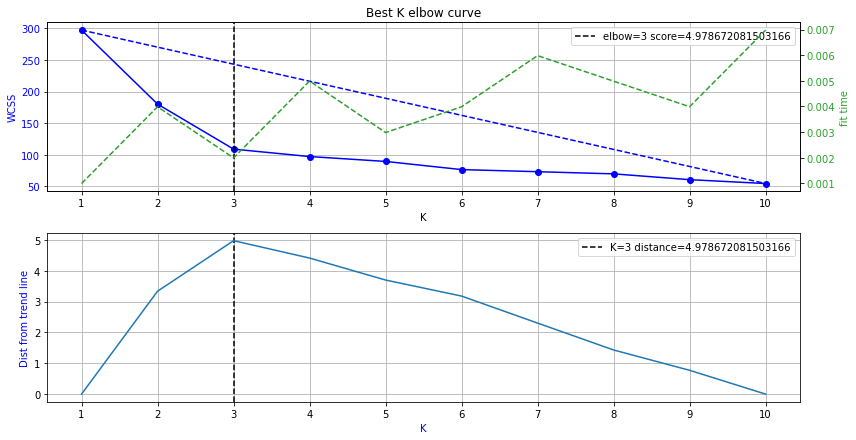

In [ ]:
# Add your code for Task 2 after this line, and keep it in this cell.
import time

def get_dist_point_from_line(point, line_start, line_end):
    d = np.linalg.norm(np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
    return np.abs(d)

WCSS = []
times = []

# We'll check the WCSS of u Ks ranging from 1 to sqrt(n).
# sqrt(t) is derived from a rule-of-thumb mention e.g in:
#  https://www.edupristine.com/blog/beyond-k-means
minK = 1
maxK = int(np.sqrt(len(EMR3d1)))
Ks = range(minK, maxK+1)
for k in Ks:
    kmeans = k_means(k=k)
    start_time = time.time()
    kmeans.fit(EMR3d1)    
    times.append(time.time() - start_time)
    WCSS.append(kmeans.get_WCSS())

# Find the best K using the "elbow" method.
# We'll look for the elbow by finding the WCSS(k) which has the largest distance from WCSS trend line

# Trend line edges:
trend_srart = np.array([minK, WCSS[0]])
trend_end = np.array([maxK, WCSS[-1]])

# compute distance from each curve point to the trend line
dists_from_trend_line = []
for i in range(len(WCSS)):
    point = np.array([Ks[i], WCSS[i]])
    dists_from_trend_line.append(
        get_dist_point_from_line(
             point, trend_srart, trend_end))

maxDist = np.max(dists_from_trend_line)
bestK = Ks[np.argmax(dists_from_trend_line)]


fig, ax = plt.subplots(2, figsize=(12,6))
ax[0].grid()
ax[1].grid()

# Plot the elbow curve:
ax_wcss = ax[0]
ax_wcss.set_xlabel('K')
ax_wcss.set_xticks(Ks)
ax_wcss.set_ylabel('WCSS', color='b')
ax_wcss.plot(Ks, WCSS, color='b', marker='o')
ax_wcss.plot([Ks[0], Ks[-1]], [WCSS[0], WCSS[-1]], linestyle='dashed', color='b')
ax_wcss.tick_params(axis='y', labelcolor='b')
ax_wcss.axvline(x=bestK, label=f'elbow={bestK} score={maxDist}', c='k', linestyle='dashed')
ax_wcss.legend()

ax_time = ax_wcss.twinx()  # instantiate a second axes that shares the same x-axis
time_color = 'tab:green'
ax_time.set_ylabel('fit time', color=time_color) 
ax_time.plot(Ks, times, color=time_color, linestyle='dashed')
ax_time.tick_params(axis='y', labelcolor=time_color)

# Plot the distance curve:
ax_dist = ax[1]
ax_dist.axvline(x=bestK, label=f'K={bestK} distance={maxDist}', c='k', linestyle='dashed')
ax_dist.set_xticks(Ks)
ax_dist.plot(Ks, dists_from_trend_line)
ax_dist.set_xlabel('K', color='b')
ax_dist.set_ylabel('Dist from trend line', color='b')
ax_dist.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Best K elbow curve")
plt.show()

We pick the best K according the "elbow method" of the WCSS as function of k.
We locate the elbow by looking for $WCSS(k)$ point which has the largest distance from the "trend line" connected the $WCSS(k_{min})$ to $WCSS(k_{max})$.

With this method we picked $k=3$.

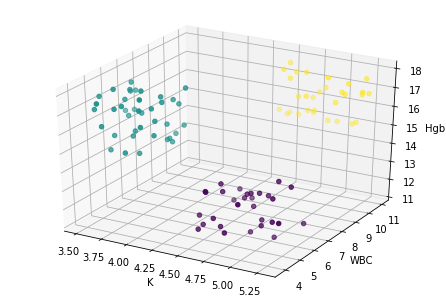

In [ ]:
km = k_means(k=3)
km.fit(EMR3d1)
y_pred_KMeans3 = km.predict(EMR3d1)
make_chart(EMR3d1, y_pred_KMeans3, variables1)


---
---
<font color='blue'>**Comment**: You could solve the task using the "elbow" method. In the solution above, the maximization of the  distance between the WCSS curve and the interpolation line was used to find an "elbow". The other implementations (like kneedle algorithm, which, actually, has the similar idea of implementation) also are possible to use. I also accepted the solution if you just visually found an "elbow" (and explained it). Also, instead of WCSS, it was possible to calculate other metrics (calinski_harabasz_score, silhouette score, etc.), - in our particular case, they give exactly the same reasonable number of clusters.  <br/> A python (Yellowbrick) implementation to the "elbow" method visuzalization can be also found [here](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html). </font>
---
---
---

### Silhouette analysis

Use graphic visualization of the Silhouette score to support your above answer:

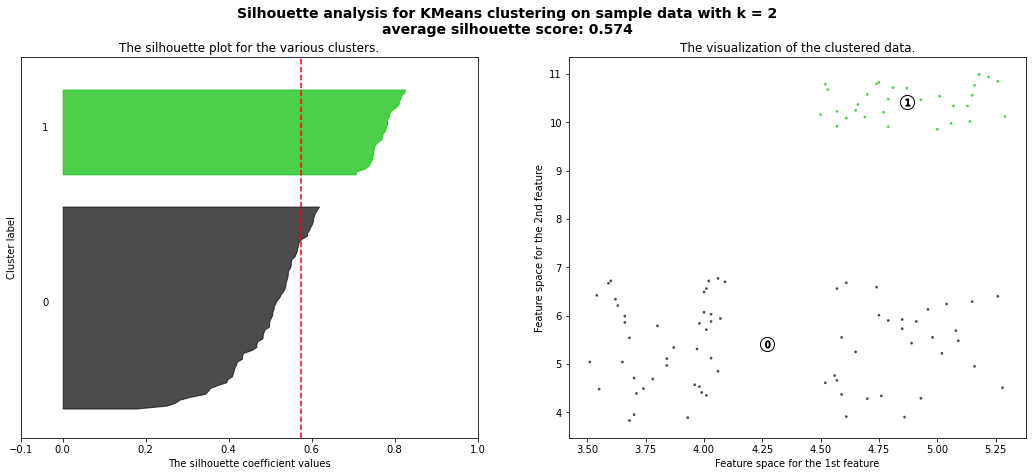

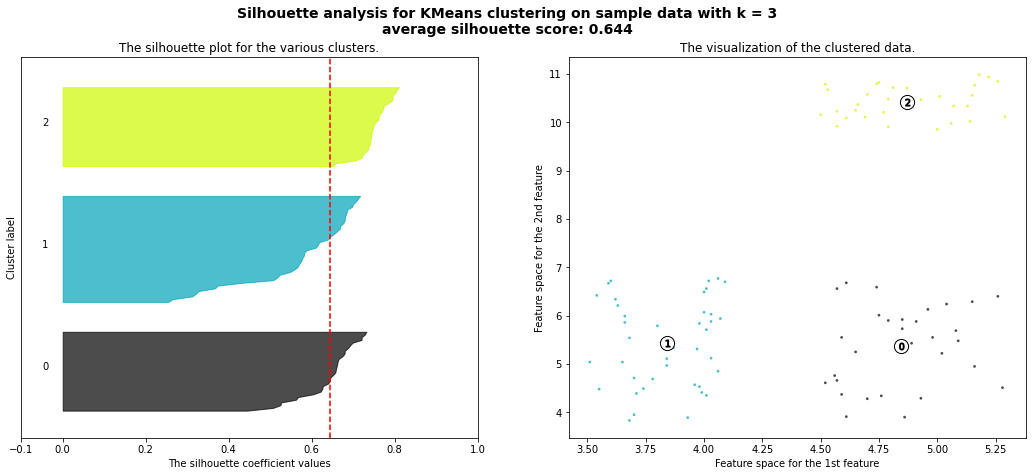

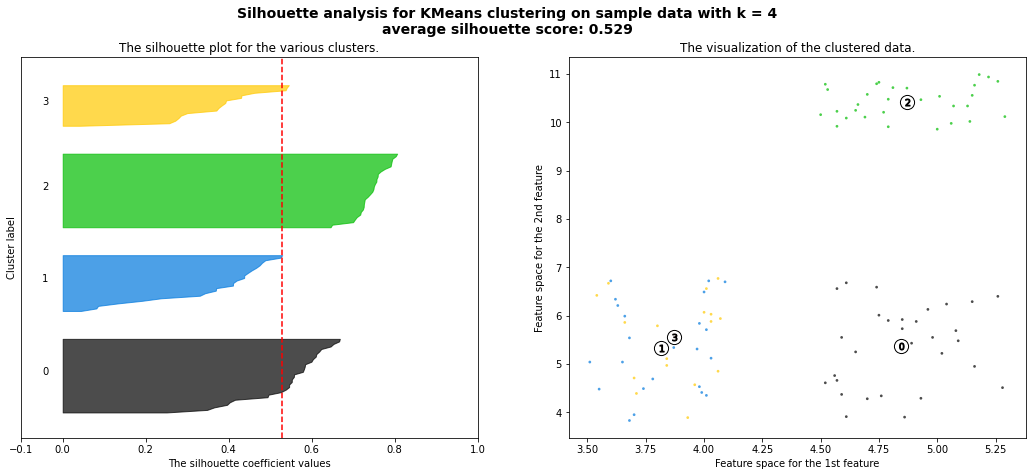

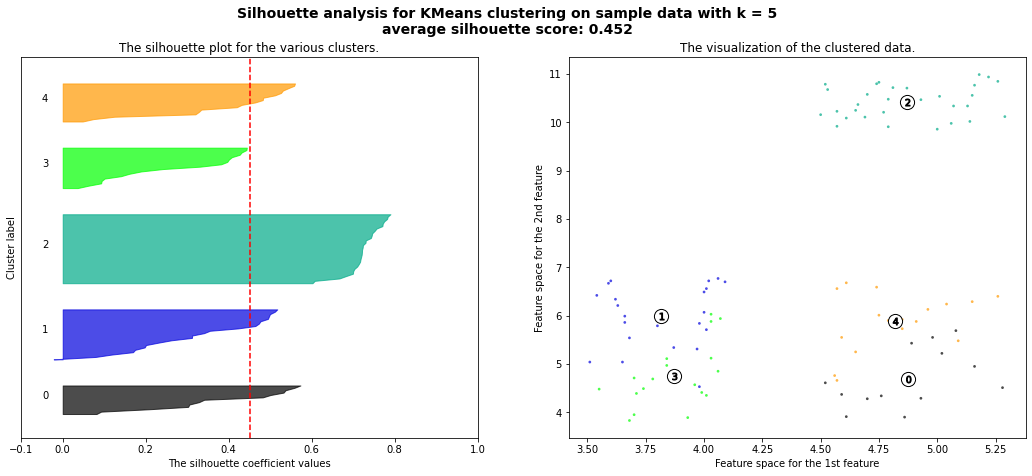

In [ ]:
# Add your code for the Sillhouette graphic analysis
# You can use scikit-learn Sillhouette page as a reference

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def plot_Silhouette(X, cluster_labels, centroids, n_clusters):    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Draw white circles at cluster centers
    ax2.scatter(
        centroids[:, 0], centroids[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centroids):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        (f"Silhouette analysis for KMeans clustering on sample data with k = {n_clusters}"
        f"\naverage silhouette score: {round(silhouette_avg,3)}"), 
        fontsize=14, fontweight='bold')

    plt.show()

X = EMR3d1
for k in [2, 3, 4, 5]:
    km = k_means(k=k, random_state=0)
    labels = km.fit_predict(X)
    centroids = km.get_centroids()
    
    plot_Silhouette(X, labels, centroids, k)

From the Silhouette plots above we get a confirmation that k=3 is a good pick.

* for k=4 and k=5, some clusters' silhouette scores are below the average
* for k=2 both clusters have some values above the average, but for clusters 0 almost all the points get less than average score. The plot for k=3 looks "better" with a bigger fraction of points crossing the average. Also the visualization of the cluster points and centroids shows that with k=2, one of the centroids is located between two visually seperable clusters.


---
---
<font color='blue'>**Comment**: All the students solved the part about the silhouette analysis correctly. </font>
---
---
---

#### From this section on - please use the sklearn Kmeans

## Part 2: Mixture Models Clustering

### Use K-Means to create clusters according to variables of both uniform and Gaussian distributions

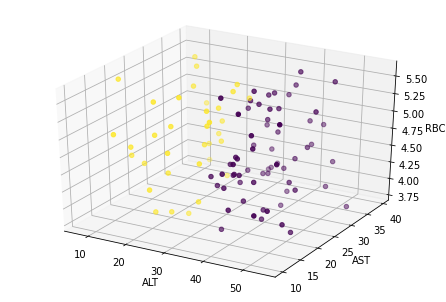

In [ ]:
# Retrieve the ALT, AST and RBC column values from the dataset to cluster
variables2 = ["ALT","AST","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values

# Run the K-Means algorithm
# NOTICE, this time, we know that the correct number of clusters is 2
y_pred_KMeans2 = KMeans(n_clusters=2, random_state=0).fit_predict(EMR3d2)

# Make a 3D chart
make_chart(EMR3d2, y_pred_KMeans2, variables2)

## Task 3
Scientists have found that in this population of patients, RBC distribution is uniform, ALT distribution is a Gaussian and AST distribution is a mixture of two Gaussians. Clearly, even by giving K-Means the correct K, the algorithm got to the wrong conclusion. This separation is "technically" correct, but lacks some underlying understanding of the natural phenomena.

What is the "problem" with this seperation?

Let's examine the distributions of ALT, AST and RBC:

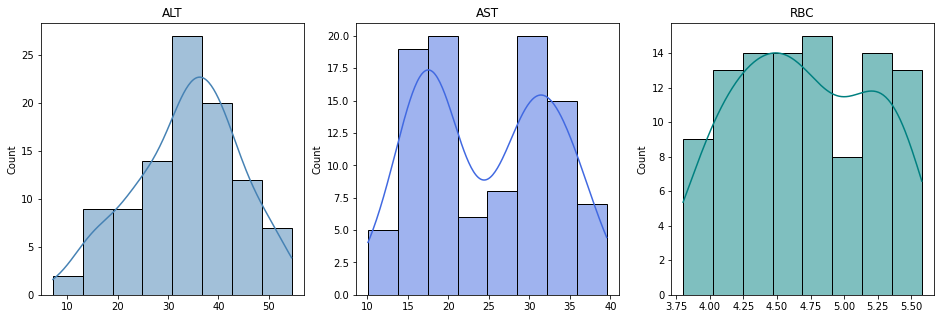

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.histplot(data=EMR3d2[:,0], kde=True, ax=axes[0], color="steelblue")
sns.histplot(data=EMR3d2[:,1], kde=True, ax=axes[1], color="royalblue")
sns.histplot(data=EMR3d2[:,2], kde=True, ax=axes[2], color="teal")

axes[0].set(title=variables2[0])
axes[1].set(title=variables2[1])
axes[2].set(title=variables2[2]);

K-Means assigns points to the clusters based on the closest centroid of each point. This works well if the data the clusters is distributed uniformally - forming spheres around the centroids.

Due to the non-uniform distribution of ALT and AST, K-means assiged samples to incorrect clusters despite getting the right K.

In order to exploit the Gaussian characteristic of the AST
1. Find the 2 componenets that comprise the AST feature by applying the GMM algorith with the proper number of components.
2. Assume that the clusters above are correct for the entire dataset (including the other features).
3. Show the final clusters (of EMR3d2) in a 3D chart

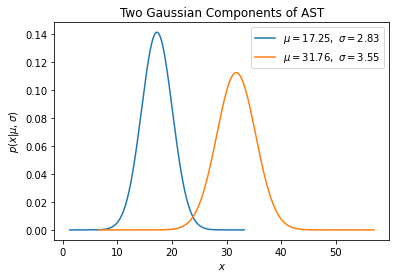

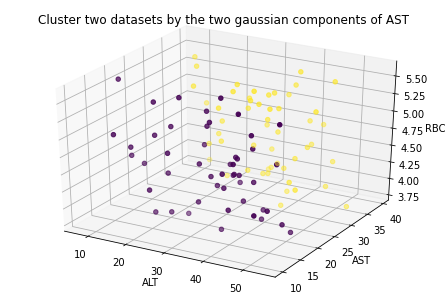

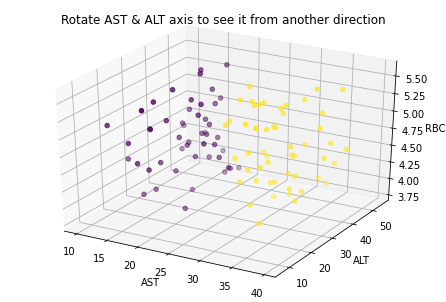

In [ ]:
# Add your code for Task 3 after this line, and keep it in this cell.

from sklearn.mixture import GaussianMixture
import scipy.stats

# Find the 2 componenets that comprise the AST feature
#   by applying the GMM algorithm on the AST feature with 2 components:
AST = EMR3d2[:, variables2.index('AST')].reshape(-1,1)
gmm = GaussianMixture(n_components=2).fit(AST)

# Plot the components:
def plot_gmm_component(gmm, i):
    mean = gmm.means_[i][0]
    std = np.sqrt(gmm.covariances_[i][0])[0]
    
    x = np.linspace(mean-2*std**2, mean+2*std**2, 1000)
    dist = scipy.stats.norm(mean, std)
    plt.plot(x, dist.pdf(x), label=f'$\mu={round(mean, 2)},\ \sigma={round(std, 2)}$')

plot_gmm_component(gmm, 0)
plot_gmm_component(gmm, 1)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Two Gaussian Components of AST')
plt.legend()
plt.show()

# Plot the clustering of the dataset in 3d,
#   assuming that it's clustered by the gaussian components of AST alone:
y_pred_gmm = gmm.predict(AST)
make_chart(EMR3d2, y_pred_gmm, variables2)
plt.title('Cluster two datasets by the two gaussian components of AST');

variables3 = ["AST", "ALT", "RBC"]
EMR3d3 = sheet1.loc[:, variables3].values
make_chart(EMR3d3, y_pred_gmm, variables3)
plt.title('Rotate AST & ALT axis to see it from another direction');

What is the difference between the two clustering results above?

Which one, given the domain knowledge provided to you, makes more sense?

The clustering by KMeans seemed to split the data mostly by ALT, while the last clustering splits the data by AST.

Given the domain knowledge that ALT has a gaussian distribution while AST is comprised of two separate gaussian distributions, it makes more sense that the dataset can be split by AST, as the ALT values are expected to be distributed around a single point unlike with AST.

---
---
<font color='blue'>**Comment**: Indeed, in this task it makes more sense to cluster only by the variable which, according to our domain knowledge, is a mixture of 2 Gaussians. The explanations, that all of you gave in this task, were good. </font>
---
---




# Good Luck!

